<a href="https://colab.research.google.com/github/BrettScheuermann/Dida325/blob/main/Final_Report_340_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Names: Allison Peteka, Yoni Stewart, Brett Scheuermann
# Dataset:
https://datasets.simula.no/kvasir-seg/
# Model Architecture:
 UNet
# Introduction
The dataset we chose is the Kvasir SEG dataset. This dataset contains 1,000 images for segmentation; this dataset did not require any data cleaning because of the smaller size of the dataset, however we did resize all of the images to 224x224 in the data block because of the varying sizes of the images. Divided up between images and masks, this dataset specifically displays image segmentation of polyps for gastrointestinal disease detection. Detecting the polyps is important because these polyps can lead to colorectal cancer. According to the American Cancer Society, colorectal cancer spreads by, "... the innermost layer (the mucosa) and can grow outward through some or all of the other layers," (What Is Colorectal Cancer?). Colorectal cancer, or CRC, is very common around the world. According to an academic article by the National Library of Medicine, "About 1.3 million new cases of colorectal cancer (CRC) are detected yearly in the world, with about 51% mortality rate, and CRC is the third most common cause of cancer mortality," (Ali et al.). There are new studies all around the world to try to lower the mortality rate of this cancer and cure it. In a recent article, one "cure" is described using anti-diabetic drugs to reduce CRC rates. Nathan Berger, the Hanna-Payne Professor of Experimental Medicine at the Case Western Reserve School of Medicine, and a lead research on this experiment says, "'Our results clearly demonstrate that GLP-1 RAs are significantly more effective than popular anti-diabetic drugs, such as Metformin or insulin, at preventing the development of CRC,' (Case Western Reserve University).

This dataset specifically deals with the polyp images that are seen through detection scans for cancer. The images show the image as it goes through the scan, and the goal of the mask is to outline the polyps themselves within the image. The documentation of the dataset acknowledges the miss rates in polyp detection of this cancer. Specifically, the miss rates range from 14 to 30 percent (Jha et al.). These miss rates on detection of cancer could lead to serious complications; miss rates on scans like this could let the cancer go undetected, which is extremely dangerous. The goal of this dataset is to experiment with the polyp automation detection, and decrease the miss rates.

We will be using this dataset to build a UNet model to test model accuracy on these masked images. The encoder of our model is ResNet18, a pretrained model which has been trained on over a million images from the ImageNet database. This model utilizes residual connections, which allows for deeper models and helps with the preservation of spatial context. After the building of this UNet model, we will be using the Dice metric, which comes out to percent, to test our accuracy model results. Our project will play with a model we have not covered in class, being the UNet model, and we will be improving it throughout to create the best Dice metric result we possibly can.

When examining other projects using this dataset, one project from a month ago used similar methods. They used image segmentation and along with many other metrics, used the Dice coefficient to determine their results. They even resized their images as well when completing their image segmentation. They resize the images to 256x256. While we will elaborate on our Dice coefficient results later in the paper, this project's Dice coefficient was 0.857. The project is located here: https://github.com/TimKong21/Polyp-Segmentation/blob/main/report/Polyp%20Segmentation%20report.pdf. In another project, the Kvasir SEG dataset was one of many used in the project. However, like us, they used a Net model for their architecture, specifically, they used the FRCNet model architecture. They also calculated their own Dice function metric called mDice, which achieved a result of 0.915. The project is located here: https://www.frontiersin.org/articles/10.3389/fbioe.2022.799541/full



Questions that drove us to use this model and this dataset:
1. Which model is best for image segmentation while requiring the least amount of training time/the free Google GPU can handle?
2. Can we find a model which is reasonable to understand and explain to the class while still presenting a challenge to us?
3. Can we improve upon any of the models that we find that are used for image segmentation?

# Code
First we will load the dataset and the imports.

**(Note: You will need to download the 44 mb version of the dataset from the link above to your Google Drive in order to run our code)**
**Before running the code please download the dataset as explained above then move it into your main Google Drive (titled MyDrive)**

In [ ]:
from google.colab import drive #the dataset is located in Google Drive so first we will import Google Drive for Google Colab

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import fastai #importing fastai and all of its functions
from fastai.vision.all import *

In [ ]:
path = Path('/content/drive/MyDrive/FullKvasir-SEG') #this path is the path to locate where in our Google Drive the dataset is located

This datablock will implement data processing for image segmentation on this dataset. It defines loading and processing with the dataset path for later for our UNet model.

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, MaskBlock), #Image Block for variables, y is mask block
                   get_items = get_image_files, #This is a function which tells the network how to find an image's corresponding mask (In the path, replace the word 'images' image with 'masks')
                   get_y = lambda x: str(x).replace('images', 'masks'),
                   splitter = RandomSplitter(seed = 2021),  #Split the data into testing and validation
                   item_tfms = [Resize(224)],
                   batch_tfms = [*aug_transforms(), FlipItem(p=1), IntToFloatTensor(div_mask = 255)]) #IntToFloatTensor(div_mask = 255) makes sure all pixel values are between zero and one

In [ ]:
dls = dblock.dataloaders(path/'images', batch_size = 32) #creating a dataloader from the block

Lets create a summary for the dataloader.

In [ ]:
dblock.summary(path/'images')

Setting-up type transforms pipelines
Found 1000 items
2 datasets of sizes 800,200
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/drive/MyDrive/FullKvasir-SEG/images/cju7d6ux323ze0987xos3srkx.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=621x527
  Pipeline: <lambda> -> PILBase.create
    starting from
      /content/drive/MyDrive/FullKvasir-SEG/images/cju7d6ux323ze0987xos3srkx.jpg
    applying <lambda> gives
      /content/drive/MyDrive/FullKvasir-SEG/masks/cju7d6ux323ze0987xos3srkx.jpg
    applying PILBase.create gives
      PILMask mode=L size=621x527

Final sample: (PILImage mode=RGB size=621x527, PILMask mode=L size=621x527)


Found 1000 items
2 datasets of sizes 800,200
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> Resize -- {'size': (224, 224), 'method': 'cro

Next, we will build our learner. Here is what we are defining in the learner:


*   learn = unet_learner defines the learner as a UNet learner, which is built into fastai already.
*   dls calls for our dataloader.

*   resnet18 is the specific architecture for our UNet model. Among many popular ResNet models, this one is a powerful CNN architecture or convolutional neural network architecture.
*   n_out = 1 sets the number out output channels in the final UNet layer. As displayed in the code, there is 1 output layer channel.

*   loss_func = BCEWithLogitsLossFlat(thresh = .4) first defines the loss function we are using, being the binary cross-entropy. This loss function compares the output with what the predicted probabilites should be. It then calculates a score which penalizes the predicted probability based on it's distance from the expected value.
*   metrics = Dice(axis =1) defines the specific metric we will be using for our results, being the Dice coefficent. axis=1 is a calulation that is being used as a defining calcualtion along the channel axis.

*   self_attention = True was a later adjustment we added to imporve our model results. It allows the mdoel to focus on various input image parts when making the predictions in the model.
*   blur_final = False simply disables blurring on the final layer of the model. Blurring is usually used in image sgementation to create smoother boundaries.
















In [ ]:
learn = unet_learner(dls, resnet18, n_out = 1, loss_func = BCEWithLogitsLossFlat(thresh = .4), self_attention = True, blur_final = False)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


In [ ]:
learn.loss_func #verifying the loss function used in the learner

FlattenedLoss of BCEWithLogitsLoss()

We are now going to train the learning model.

In [ ]:
learn.unfreeze() #Allows training of more than just the final layer (necessary for pretrained models)

In [ ]:
learn.fit_one_cycle(30, 4.46683588961605e-05)

epoch,train_loss,valid_loss,time
0,0.572242,0.510423,04:22
1,0.519252,0.439061,00:30
2,0.463098,0.334958,00:32
3,0.386987,0.339105,00:31
4,0.325569,0.205034,00:30
5,0.264986,0.180047,00:31
6,0.217165,0.201040,00:30
7,0.180703,0.170803,00:31
8,0.154236,0.165694,00:30
9,0.135855,0.155037,00:30


epoch,train_loss,valid_loss,time
0,0.572242,0.510423,04:22
1,0.519252,0.439061,00:30
2,0.463098,0.334958,00:32
3,0.386987,0.339105,00:31
4,0.325569,0.205034,00:30
5,0.264986,0.180047,00:31
6,0.217165,0.201040,00:30
7,0.180703,0.170803,00:31
8,0.154236,0.165694,00:30
9,0.135855,0.155037,00:30


Both of the losses start off at about .5. While the training loss continues to decrease the validation loss starts out very high, and then decreases significantly until it reaches about .15 where the loss planes off and stays at around that value. We'll now define a function which will plot a dice metric and show the best dice metric of our model, or show us the best predicted masks of the model. We also tried running the model for 50 epochs but received similar results and deemed it unnecessary to run the model for anymore epochs.

The image results.

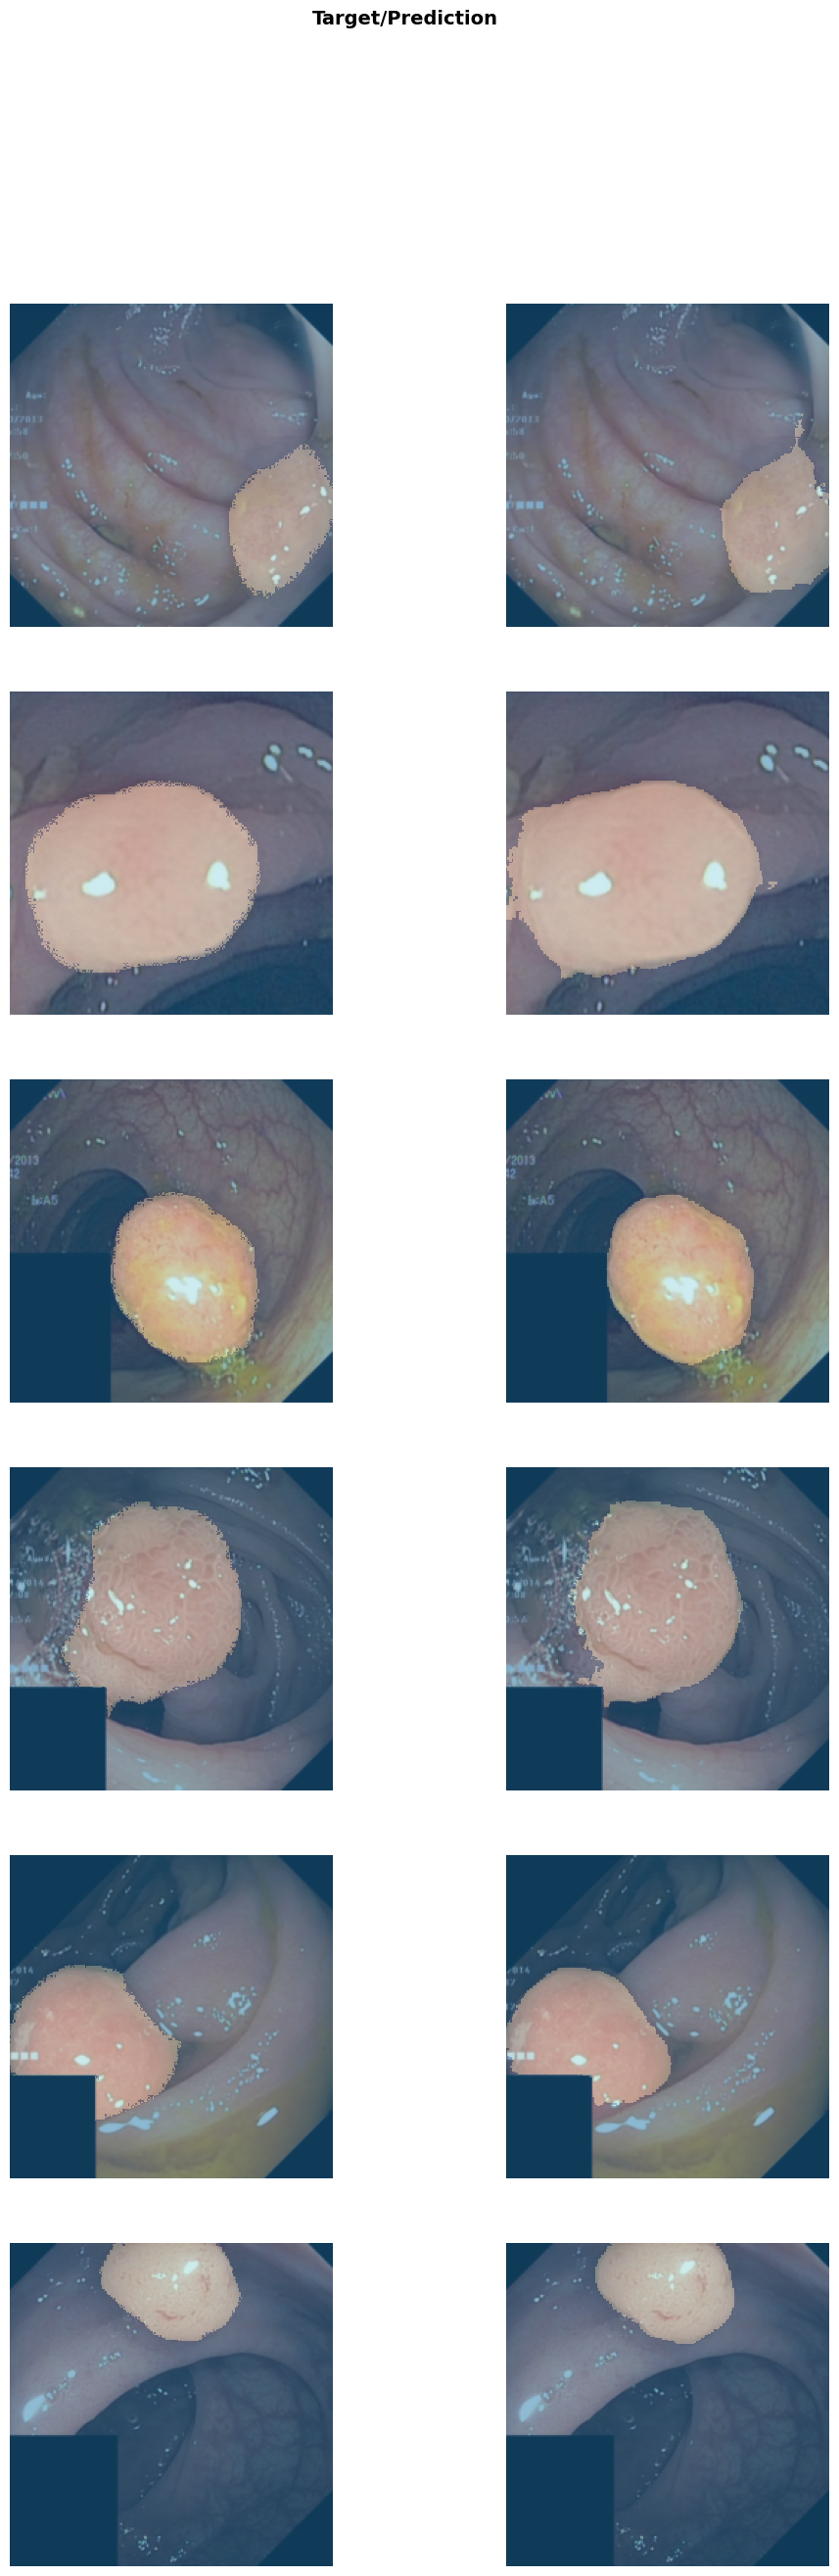

In [ ]:
learn.show_results(max_n=6, figsize=(12,30))

Analyzing the images, masks, and the predicted losses from it.  These losses represent the error on the model from predicting what the target mask should be, this loss is an average of all the pixels to see which were correctly predicted and which were incorrectly predicted. As we can see from some of the examples, the model does a pretty good job predicting the general body of the mask but has trouble getting the all the fine details.

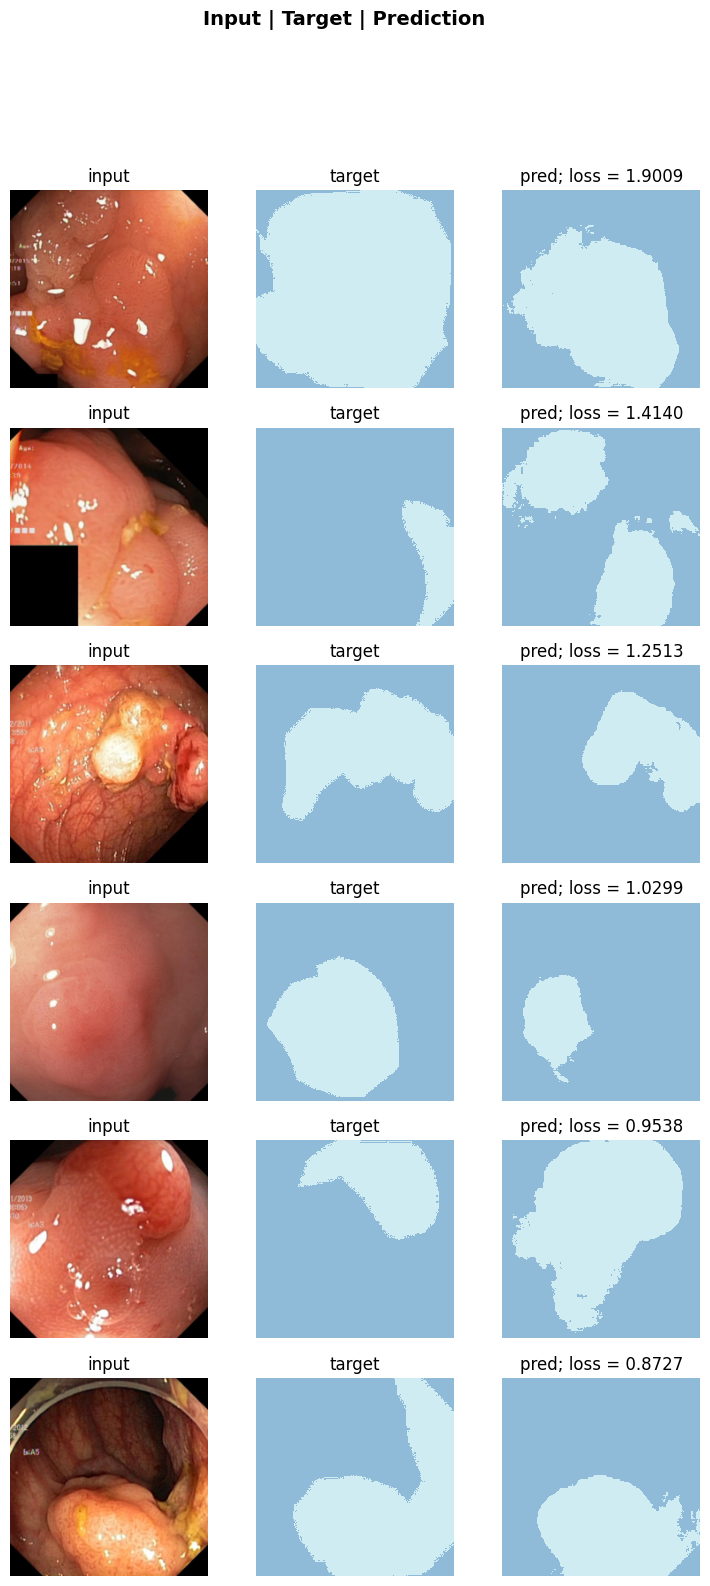

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=6)

This line of code obtains the predicted values from the trained model learner.

In [ ]:
preds, ys = learn.get_preds()

This is creating a function for calculating the Dice coefficent. We will then calculate various Dice coefficents for different predictions.

In [ ]:
def dice_overall(preds, targs): #defining the function with two arguements, preds (predicted values) and targs (targets)
    n = preds.shape[0] #number of examples in the batch
    preds = preds.view(n, -1) #flats predicted values into a tensor
    targs = targs.view(n, -1) #flattens targets into a tensor
    intersect = (preds * targs).sum(-1).float() #calculates the sum of the multiplication of the predictions and targets
    union = (preds+targs).sum(-1).float()
    u0 = union==0 #finds where union is 0 to avoid dividing by 0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union) #calculate the Dice coefficent and returns the result

In [ ]:
dices = [] #empty list to store the Dice coefficents
thrs = np.arange(0.01, 1, 0.01) #creates an array, MAYBE DESCRIBE MORE OF WHAT THE ARRAY DOES
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean()) #calls the dice_overall function and adds calculated values to the dices list
dices = np.array(dices) #converts list of Dice coefficents into an array


In [19]:
dices.max(), thrs[dices.argmax()] #prints the max value in the list as well as WHAT DOES THE SECOND PART DO??

(0.833976, 0.46)

Creating a graph with our best Dice coefficent.

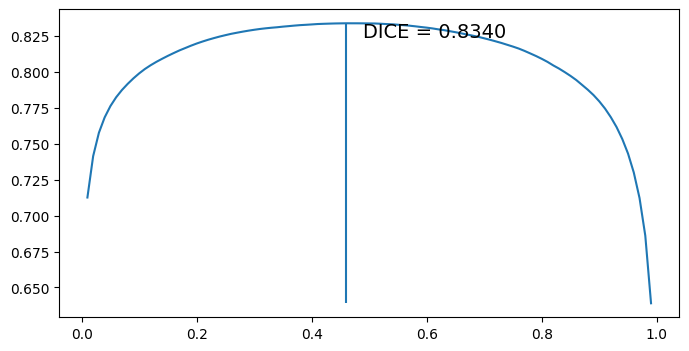

In [20]:
best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.4f}', fontsize=14);
plt.show()

In [21]:
dices[30]

0.8300065

# Analysis
As the dataset came with only 1,000 images, cleaning of the dataset was not needed (other than the resizing). This smaller dataset allowed us to use the entire set in our model without overpowering the GPU time. This also allowed us for more accuracy in our results, as we did not need to trim down the data.
We came in with the challenge of creating an effective and accurate UNet model using this dataset for analysis. After determining various factors needed for this model, such as what loss function we were going to use, and what metric did we want to anaylze the dataset on, we were able to run our model and determine results effectively. In the end, we had a quick and smooth-running model with a Dice coefficent at the end to analyze.

Our model starts by taking the dataset into a data block, and puts the images through specific augmentations to improve the models accuracy by making the images uniform size of 224x224 and augmenting the data to give the model more information (we only used image flipping, so to need feed the model poorly cropped images), we then use the UNet learner in the fast ai library which is a built in UNet model to the fast ai library. This Unet library allows us to skip over coding the entire UNet by hand and use a preconstructed model which saves significant time coding, which could then be used to focus on improving the accuracy of the model. We then trained the model for many epochs and evaluated the model. We also compared the pictures of what our model’s predicted mask is with the true mask to see where the model is missing or adding too many pixels to visualize what we can do to improve the model.

How does our model compare to the other models? Our model is very similar to the model on github; the model on github downsizes the image to 256x256, this model then augments the data significantly more than our model did. Which we felt was unnecessary for improving the accuracy of the model. This github model also used several other metrics to assess the accuracy of their model. The model on frontiers used several different datasets to test their model on and instead of using a Unet to train their model, the frontier group used a FRCNet. This model is very similar to the UNet model but builds on the UNet model and adds a few new features to decrease the complexity of the model.


The general idea behind the dice coefficient is that it is a spatial overlap index, so it tracks the overlap of a model's output with what the predicted output should be, and grades the model based on a scale from 0 to 1. This metric is also referred to as a reproducibility validation metric. So the dice coefficient is grading how close our UNet model’s output is to the predicted mask. The highest dice coefficient that we were able to achieve was .85, which is an 85% accuracy of our model predicting the pixels of the mask. This output is very similar to the previously mentioned models that we compared ours to. The group from github was also able to achieve a dice coefficient of .85, and the group that posted on frontiers was able to achieve a dice score of .915 with their model. So our model’s accuracy was near the other model’s accuracy that we compared our model to. So overall, with an accuracy we can compare to other models, we determined that ours was a success.
# Conclusion
While there were challenges in completing this project, we also learned a lot. We learned about the infrastructure of a UNet deep learning model, about the biological elements that make up the dataset, and how to anaylze the dataset using the model. This project took a lot of time, effort, and trials, but the finished product ended up being a success.